<div style="font-size:37px; font-weight:bold; line-height:1.1">
    Computer-aided exploration of the Martian geology
</div>

<p style="color:rgb(90,90,90);">
The MIT License (MIT)
<br>
Copyright (c) 2018 Massachusetts Institute of Technology
</p>
<p style="color:rgb(90,90,90);">
Author: Guillaume Rongier
<br>
We acknowledge support from NSF ACI1442997 (PI: V. Pankratius) and NASA AISTNNX15AG84G (PI: V. Pankratius).
</p>
<p style="color:rgb(90,90,90);">
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
</p>
<ul style="color:rgb(90,90,90);">
<li>The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.</li>
<li>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</li>
</ul>

This notebook is part of a set of notebooks to compute a favorability map for the selection of landing sites on Mars. A favorable site depends on two main constraints:
* Landing constraints which ensure that the system can land on a given area.
* Scientific targets which must be visited by a rover after landing, if the rover can drive to them.

The notebooks determine this favorability for a rover similar to NASA's Mars 2020 rover at 20 pixels per degree (3 km per pixel at the equator), and investigate our ability to explore Mars with enhanced landing and roving capabilities.

# Gathering the landing and traverse constraints

Our goal here is to gather all the data defining the landing constraints and the rover mobility, convert them into a raster format if needed, and save all the rasters in a single directory.

## Package imports

Load some functions for data import, data visualization, and favorability computation.

In [1]:
%matplotlib notebook

from skdiscovery.utilities.planetary.raster_management import *
from skdiscovery.utilities.planetary.vector_management import *
from skdiscovery.utilities.planetary.geographical_computation import compute_longitude_and_latitude_maps
from skdiscovery.utilities.planetary.morphometry import *

import matplotlib.pyplot as plt

from skimage.transform import resize
import struct

## Setting

Geographical setting for the rasters.

In [2]:
mars_radius = 3389500. # meters

master_lon_min = -180.
master_lon_max = 180.
master_lat_min = -90.
master_lat_max = 90.
master_extent = (master_lon_min, master_lon_max, master_lat_min, master_lat_max)

master_width = 7200
master_height = 3600
master_geotransform = define_geotransform(master_lon_min, master_lon_max, 
                                          master_lat_min, master_lat_max, 
                                          master_width, master_height)
master_projection = '''PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0]]'''

master_spatial_reference_system = osr.SpatialReference(wkt = master_projection)
master_central_meridian = 0.

Folder structure from the base folder *CaseStudyMars_Data*:
<pre>
Base folder:   CaseStudyMars_Data/
               ├── Original_Data/
               │   ├── Interpreted_Data/
               │   ├── MEX/
               │   │   ├── HRSC/
               │   │   └── OMEGA/
               │   ├── MGS/
               │   │   ├── MOLA/
               │   │   └── TES/
               │   ├── MRO/
               │   │   ├── CRISM/
               │   │   └── HiRISE/
Output folder: └── Raster_Data_20ppd/
</pre>

In [3]:
base_folder = '/data/Mars/CaseStudyMars_Data/'
output_folder = 'Raster_Data_20ppd/'

## Data to download before running the notebook

You can find below all the links to the data. The notebook does all the processing on these data to get the landing constraints in raster format, and can be run directly after data downloading the data.

**MOLA 32 ppd elevation (32 ppd = 1.852 km per pixel at the equator) [from PDS Geosciences Node]**  
*In CaseStudyMars_Data/Original_Data/MGS/MOLA/*  
http://pds-geosciences.wustl.edu/mgs/mgs-m-mola-5-megdr-l3-v1/mgsl_300x/meg032/megt90n000fb.lbl  
http://pds-geosciences.wustl.edu/mgs/mgs-m-mola-5-megdr-l3-v1/mgsl_300x/meg032/megt90n000fb.img  
**MOLA 128 ppd elevation (128 ppd = 0.463 km per pixel at the equator) [from USGS]**  
*In CaseStudyMars_Data/Original_Data/MGS/MOLA/*  
https://planetarymaps.usgs.gov/mosaic/Mars_MGS_MOLA_DEM_mosaic_global_463m.tif  
**Thermophysical surface units [from Planetary Science Institute]**  
*In CaseStudyMars_Data/Original_Data/MGS/TES/*  
https://se.psi.edu/~than/inertia/2007/ANBunits2007.bin  

**MRO HiRISE DTM footprints [from PDS Geosciences Node]**  
*In CaseStudyMars_Data/Original_Data/MRO/HiRISE/*  
http://ode.rsl.wustl.edu/mars/datafile/derived_products/coverageshapefiles/mars/mro/hirise/dtm/mars_mro_hirise_dtm_c0a.zip  
**HRSC DTMRDR footprints [from PDS Geosciences Node]**  
*In CaseStudyMars_Data/Original_Data/MRO/HRSC/*  
http://ode.rsl.wustl.edu/mars/datafile/derived_products/coverageshapefiles/mars/mex/hrsc/dtmrdr/mars_mex_hrsc_dtmrdr_c0a.zip  
**MRO HiRISE RDR footprints [from PDS Geosciences Node]**  
*In CaseStudyMars_Data/Original_Data/MRO/HiRISE/*  
http://ode.rsl.wustl.edu/mars/datafile/derived_products/coverageshapefiles/mars/mro/hirise/rdrv11/mars_mro_hirise_rdrv11_c0a.zip  
http://ode.rsl.wustl.edu/mars/datafile/derived_products/coverageshapefiles/mars/mro/hirise/rdr/mars_mro_hirise_rdr_c0a.zip  
**MRO CRISM TRDR/DDR FRT/HRL/HRS/FRS/ATO/ATU footprints [from PDS Geosciences Node]**  
*In CaseStudyMars_Data/Original_Data/MRO/CRISM/*  
http://ode.rsl.wustl.edu/mars/datafile/derived_products/coverageshapefiles/mars/mro/crism/trdrddrfrt/mars_mro_crism_trdrddrfrt_c0a.zip  

## Engineering constraints

These constraints define the areas where landing is possible.

### Latitudes

All the processing in this notebook follow to steps: First create the map.

In [4]:
longitude_array, latitude_array = compute_longitude_and_latitude_maps(master_lon_min, master_lon_max, 
                                                                      master_lat_min, master_lat_max, 
                                                                      master_width, master_height)

<IPython.core.display.Javascript object>


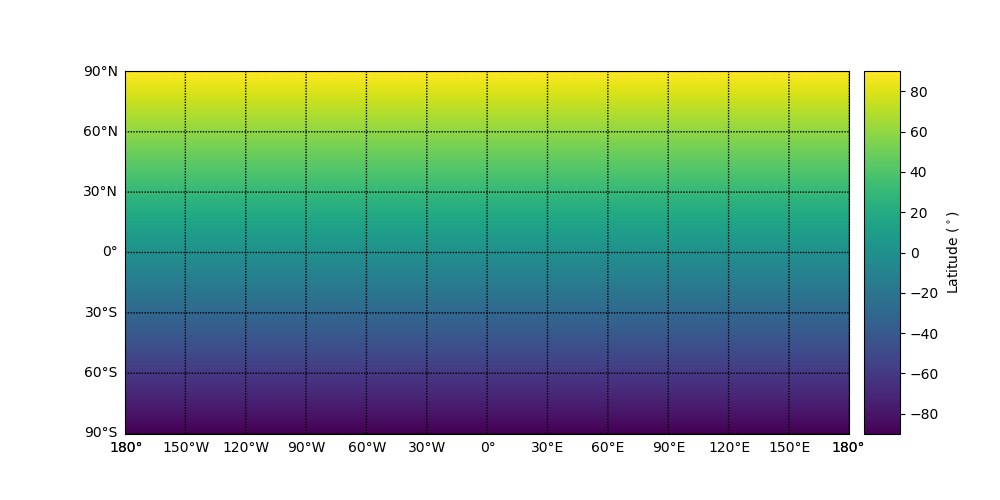

In [5]:
figure1 = plt.figure(figsize = (10, 5))
subfigure1 = figure1.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, latitude_array, 'Latitude ($^\circ$)')
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

Then, export the maps to a .tif file.

In [6]:
raster_latitude = create_raster_from_array(latitude_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = base_folder + output_folder + 'Other_Data_Latitude.tif',
                                           options = ['COMPRESS=DEFLATE', 'PREDICTOR=3', 'TILED=YES'])
raster_latitude = None

In [7]:
longitude_array = None
latitude_array = None

### Topography

**Elevation**

MOLA 32 ppd elevation from: http://pds-geosciences.wustl.edu/missions/mgs/megdr.html

We recenter the 32 ppd elevation map from a 0 to 360 &deg;E extent to a -180 to 180 &deg;E extent, then upscale the resulting map to 20 ppd.

In [8]:
raster_elevation = open_raster(base_folder + 'Original_Data/MGS/MOLA/megt90n000fb.lbl')
print_raster_info(raster_elevation)
raster_elevation_array = get_raster_array(raster_elevation)

raster_elevation_reference_system = osr.SpatialReference(wkt = raster_elevation.GetProjection())
raster_elevation_central_meridian = raster_elevation_reference_system.GetProjParm("central_meridian", -99999.)
raster_elevation_upscaled_array = recenter_raster_array(raster_elevation_array, 
                                                        master_central_meridian, 
                                                        raster_elevation_central_meridian, 
                                                        master_lon_min, 
                                                        master_lon_max)

raster_elevation = None
raster_elevation_array = None

raster_elevation_upscaled_array = resize(raster_elevation_upscaled_array,
                                         (master_height, master_width),
                                         order = 3,
                                         mode = 'reflect')

Driver:  PDS / NASA Planetary Data System
Size of the cube is  11520 x 5760 x 1
Projection is  PROJCS["SIMPLE_CYLINDRICAL MARS",GEOGCS["GCS_MARS",DATUM["D_MARS",SPHEROID["MARS",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",180],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0]]
Origin = ( -10675133.0 , 5338493.0 )
Pixel Size = ( 1853.0 , -1853.0 )


<IPython.core.display.Javascript object>


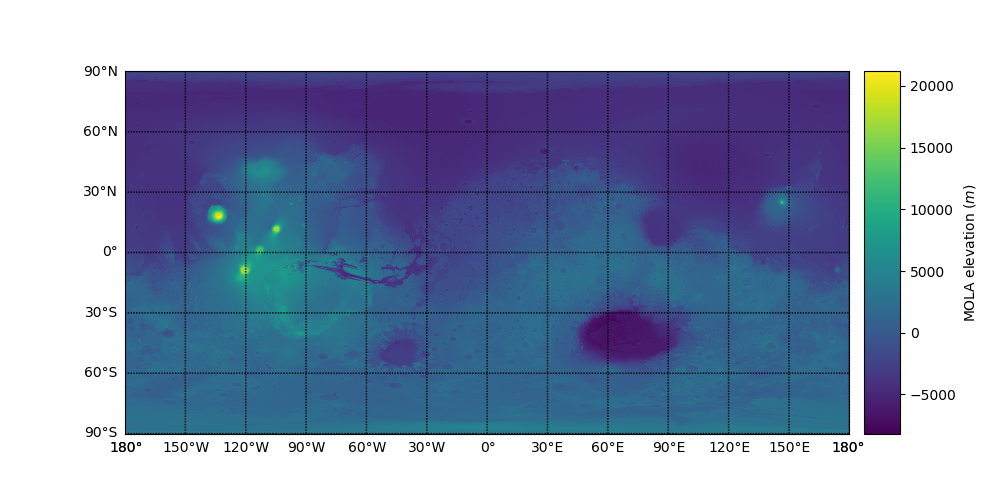

In [9]:
figure1 = plt.figure(figsize = (10, 5))
subfigure1 = figure1.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, raster_elevation_upscaled_array, 'MOLA elevation ($m$)')
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

Export the map to a .tif file.

In [10]:
raster_elevation_upscaled = create_raster_from_array(raster_elevation_upscaled_array,           
                                                     master_geotransform, 
                                                     master_projection,
                                                     file_type = 'GTiff',
                                                     file_path = base_folder + output_folder + 'MGS_MOLA_Elevation.tif',
                                                     options = ['COMPRESS=DEFLATE', 'PREDICTOR=3', 'TILED=YES'])
raster_elevation_upscaled = None

In [11]:
raster_elevation_upscaled_array = None

**Standard deviation of elevation at 1 km baseline**

MOLA 128 ppd elevation from: https://astrogeology.usgs.gov/search/map/Mars/GlobalSurveyor/MOLA/Mars_MGS_MOLA_DEM_mosaic_global_463m

We compute the standard devation of elevation at 1 km baseline using the 128 ppd elevation map, then upscale the resulting map to 20 ppd.

&#9888; The computation at 128 ppd takes a few minutes.

In [12]:
%%time

raster_elevation_128ppd = open_raster(base_folder + 'Original_Data/MGS/MOLA/Mars_MGS_MOLA_DEM_mosaic_global_463m.tif')
print_raster_info(raster_elevation_128ppd)
raster_elevation_128ppd_array = get_raster_array(raster_elevation_128ppd)

raster_std_elevation_1km_array = compute_absolute_standard_deviation_filter(raster_elevation_128ppd_array,
                                                                            window_size = 3)

raster_elevation_128ppd = None
raster_elevation_128ppd_array = None

raster_std_elevation_1km_array = resize(raster_std_elevation_1km_array,
                                        (master_height, master_width),
                                        order = 3,
                                        mode = 'reflect')

Driver:  GTiff / GeoTIFF
Size of the cube is  46080 x 23040 x 1
Projection is  PROJCS["Equirectangular Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars_localRadius",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -10669675.197320545 , 5334837.598660273 )
Pixel Size = ( 463.0935415503709 , -463.0935415503709 )
CPU times: user 4min 40s, sys: 6min 41s, total: 11min 22s
Wall time: 11min 27s


<IPython.core.display.Javascript object>


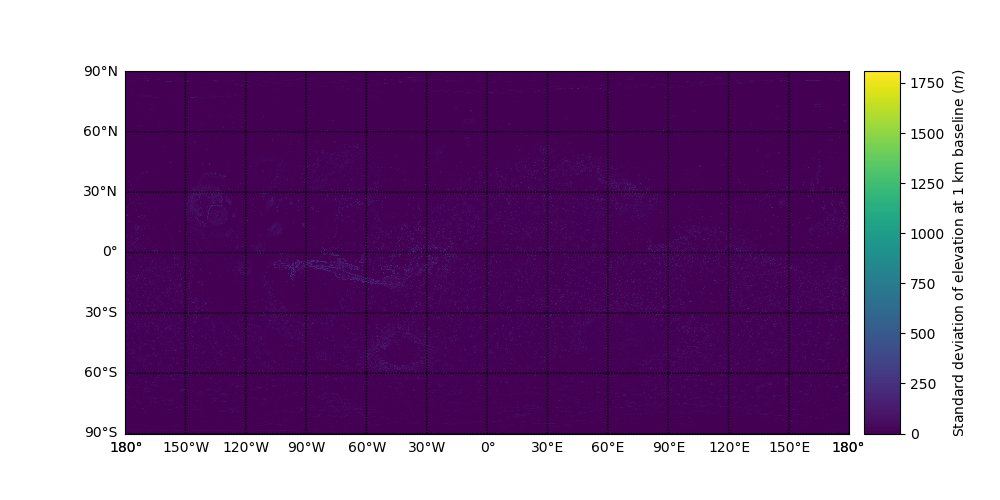

In [13]:
figure1 = plt.figure(figsize = (10, 5))
subfigure1 = figure1.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, raster_std_elevation_1km_array, 'Standard deviation of elevation at 1 km baseline ($m$)')
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

Export the map to a .tif file.

In [14]:
raster_std_elevation_1km = create_raster_from_array(raster_std_elevation_1km_array,           
                                                    master_geotransform, 
                                                    master_projection,
                                                    file_type = 'GTiff',
                                                    file_path = base_folder + output_folder + 'MGS_MOLA_Std_Elevation_1km.tif',
                                                    options = ['COMPRESS=DEFLATE', 'PREDICTOR=3', 'TILED=YES'])
raster_std_elevation_1km = None

In [15]:
raster_std_elevation_1km_array = None

**Standard deviation of elevation at 2 km baseline**

MOLA 128 ppd elevation from: https://astrogeology.usgs.gov/search/map/Mars/GlobalSurveyor/MOLA/Mars_MGS_MOLA_DEM_mosaic_global_463m

We compute the standard devation of elevation at 2 km baseline using the 128 ppd elevation map, then upscale the resulting map to 20 ppd.

&#9888; The computation at 128 ppd takes a few minutes.

In [16]:
%%time

raster_elevation_128ppd = open_raster(base_folder + 'Original_Data/MGS/MOLA/Mars_MGS_MOLA_DEM_mosaic_global_463m.tif')
print_raster_info(raster_elevation_128ppd)
raster_elevation_128ppd_array = get_raster_array(raster_elevation_128ppd)

raster_std_elevation_2km_array = compute_absolute_standard_deviation_filter(raster_elevation_128ppd_array,
                                                                            window_size = 5)

raster_elevation_128ppd = None
raster_elevation_128ppd_array = None

raster_std_elevation_2km_array = resize(raster_std_elevation_2km_array,
                                        (master_height, master_width),
                                        order = 3,
                                        mode = 'reflect')

Driver:  GTiff / GeoTIFF
Size of the cube is  46080 x 23040 x 1
Projection is  PROJCS["Equirectangular Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars_localRadius",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -10669675.197320545 , 5334837.598660273 )
Pixel Size = ( 463.0935415503709 , -463.0935415503709 )
CPU times: user 6min 52s, sys: 7min 6s, total: 13min 58s
Wall time: 14min 3s


<IPython.core.display.Javascript object>


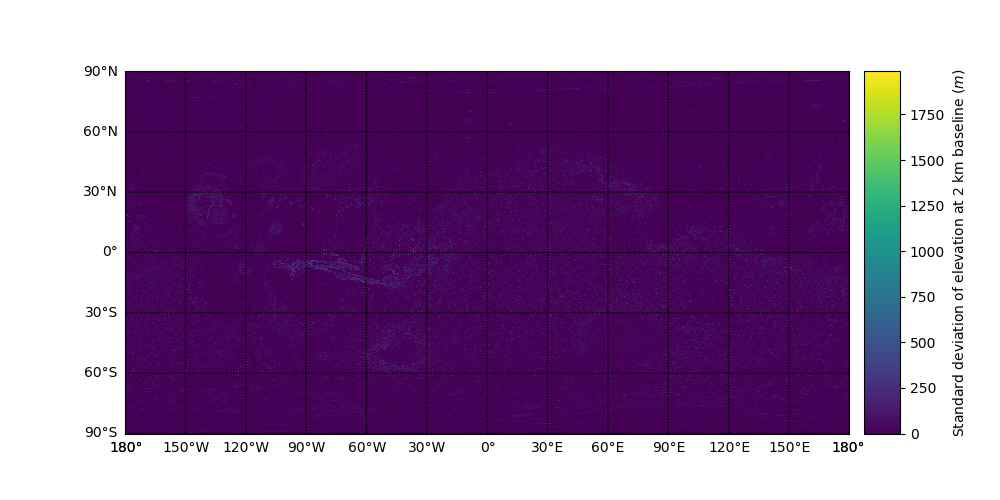

In [17]:
figure1 = plt.figure(figsize = (10, 5))
subfigure1 = figure1.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, raster_std_elevation_2km_array, 'Standard deviation of elevation at 2 km baseline ($m$)')
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

Export the map to a .tif file.

In [18]:
raster_std_elevation_2km = create_raster_from_array(raster_std_elevation_2km_array,           
                                                    master_geotransform, 
                                                    master_projection,
                                                    file_type = 'GTiff',
                                                    file_path = base_folder + output_folder + 'MGS_MOLA_Std_Elevation_2km.tif',
                                                    options = ['COMPRESS=DEFLATE', 'PREDICTOR=3', 'TILED=YES'])
raster_std_elevation_2km = None

In [19]:
raster_std_elevation_2km_array = None

**Slope at 1 km baseline**

MOLA 128 ppd elevation from: https://astrogeology.usgs.gov/search/map/Mars/GlobalSurveyor/MOLA/Mars_MGS_MOLA_DEM_mosaic_global_463m

We compute the slope at 1 km baseline using the 128 ppd elevation map, then upscale the resulting map to 20 ppd.

&#9888; The computation at 128 ppd takes about ten minutes.

In [20]:
%%time

raster_elevation_128ppd = open_raster(base_folder + 'Original_Data/MGS/MOLA/Mars_MGS_MOLA_DEM_mosaic_global_463m.tif')
print_raster_info(raster_elevation_128ppd)
raster_elevation_128ppd_array = get_raster_array(raster_elevation_128ppd)
raster_elevation_128ppd_width = raster_elevation_128ppd_array.shape[1]
raster_elevation_128ppd_height = raster_elevation_128ppd_array.shape[0]

longitude_array, latitude_array = compute_longitude_and_latitude_maps(master_lon_min, master_lon_max, 
                                                                      master_lat_min, master_lat_max, 
                                                                      raster_elevation_128ppd_width, raster_elevation_128ppd_height)

raster_slope_1km_array = compute_horne_slope(raster_elevation_128ppd_array, 
                                             longitude_array, 
                                             latitude_array, 
                                             mars_radius)

raster_elevation_128ppd = None
raster_elevation_128ppd_array = None
longitude_array = None
latitude_array = None

raster_slope_1km_array = resize(raster_slope_1km_array,
                                (master_height, master_width),
                                order = 3,
                                mode = 'reflect')

Driver:  GTiff / GeoTIFF
Size of the cube is  46080 x 23040 x 1
Projection is  PROJCS["Equirectangular Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars_localRadius",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -10669675.197320545 , 5334837.598660273 )
Pixel Size = ( 463.0935415503709 , -463.0935415503709 )
CPU times: user 23min 59s, sys: 17min 2s, total: 41min 2s
Wall time: 40min 48s


<IPython.core.display.Javascript object>


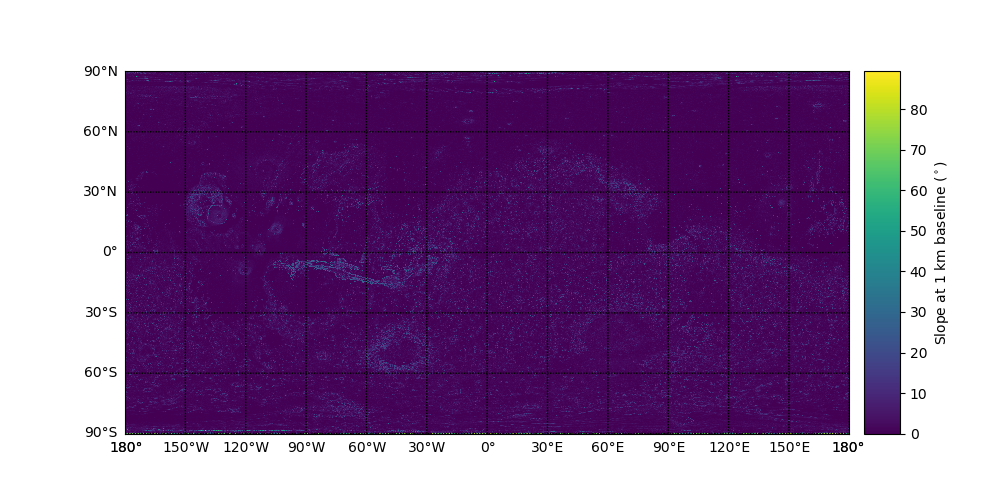

In [21]:
figure1 = plt.figure(figsize = (10, 5))
subfigure1 = figure1.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, raster_slope_1km_array, 'Slope at 1 km baseline ($^\circ$)')
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

Export the map to a .tif file.

In [22]:
raster_slope_1km = create_raster_from_array(raster_slope_1km_array,           
                                            master_geotransform, 
                                            master_projection,
                                            file_type = 'GTiff',
                                            file_path = base_folder + output_folder + 'MGS_MOLA_Slope_1km.tif',
                                            options = ['COMPRESS=DEFLATE', 'PREDICTOR=3', 'TILED=YES'])
raster_slope_1km = None

In [23]:
raster_slope_1km_array = None

### Thermophysical surface units

https://se.psi.edu/~than/inertia/2007/units.html

We read the .bin data and put them into a NumPy array.

In [24]:
# https://stackoverflow.com/questions/12163549/python-unpack-little-endian
raster_thermophy_path = base_folder + 'Original_Data/MGS/TES/ANBunits2007.bin'
raster_thermophy_header_length = 7200
raster_thermophy_width = 7200
raster_thermophy_height = 3600
raster_thermophy_scale = 1
raster_thermophy_offset = 0

raster_thermophy_file = open(raster_thermophy_path, 'rb')
raster_thermophy_file.read(raster_thermophy_header_length)
raster_thermophy_data = struct.unpack('<' + '%dB'%(raster_thermophy_width*raster_thermophy_height), 
                                     raster_thermophy_file.read(raster_thermophy_width*raster_thermophy_height))
raster_thermophy_array = np.array(raster_thermophy_data).reshape(raster_thermophy_height, 
                                                           raster_thermophy_width).astype(np.float)

raster_thermophy_array = raster_thermophy_array[::-1, ::-1]*raster_thermophy_scale + raster_thermophy_offset
raster_thermophy_array[raster_thermophy_array == 0] = np.nan
raster_thermophy_array = recenter_raster_array(raster_thermophy_array, 180, 0, 0, 360)

raster_thermophy_array[raster_thermophy_array == 250.] = 6
raster_thermophy_array[raster_thermophy_array == 208.] = 7
raster_thermophy_array[raster_thermophy_array == 192.] = 2
raster_thermophy_array[raster_thermophy_array == 144.] = 3
raster_thermophy_array[raster_thermophy_array == 96.] = 4
raster_thermophy_array[raster_thermophy_array == 72.] = 1
raster_thermophy_array[raster_thermophy_array == 24.] = 5

<IPython.core.display.Javascript object>


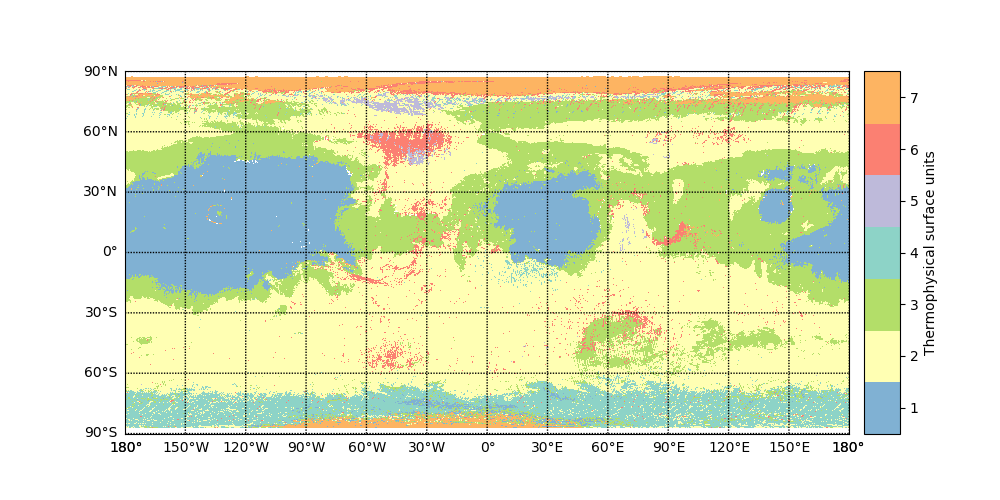

In [25]:
cmap_putzig = colors.ListedColormap(['#80b1d3', '#ffffb3', '#b3de69', '#8dd3c7', '#bebada', '#fb8072', '#fdb462'])
boundaries = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]
norm = colors.BoundaryNorm(boundaries, cmap_putzig.N)
ticks = [1, 2, 3, 4, 5, 6, 7]
discrete_colormap = DiscreteColormap(cmap_putzig, norm, boundaries, ticks)

figure1 = plt.figure(figsize = (10, 5))
subfigure1 = figure1.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, raster_thermophy_array, 'Thermophysical surface units', colormap = discrete_colormap)
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

Export the map to a .tif file.

In [26]:
raster_thermophy = create_raster_from_array(raster_thermophy_array,           
                                            master_geotransform, 
                                            master_projection,
                                            file_type = 'GTiff',
                                            file_path = base_folder + output_folder + 'MGS_TES_Thermophysical_Surface_Units.tif',
                                            options = ['COMPRESS=DEFLATE', 'PREDICTOR=3', 'TILED=YES'])
raster_thermophy = None

In [27]:
raster_thermophy_array = None

## High-resolution data footprints

The high-resolution data footprints highlight the areas where more local and detailed studies are possible.

For more details about the footprints, see https://isis.astrogeology.usgs.gov/IsisSupport/index.php?topic=2578.0

### Elevation

**HiRISE**

http://ode.rsl.wustl.edu/mars/coverage/ODE_Mars_shapefile.html

MRO HiRISE DTM Coverage Files  
Resolution: 1 - 2 m/px

For each case, we import and rasterize the shapefile.

In [28]:
shapefile_hirise_dtm_footprints = open_shapefile(base_folder + 'Original_Data/MRO/HiRISE/mars_mro_hirise_dtm_c0a/mars_mro_hirise_dtm_c0a.shp')

print_shapefile_field_names(shapefile_hirise_dtm_footprints)

 _______________________________________________________________________________
/ Shapefile field names:
| 
| CenterLat | CenterLon | MaxLat | MinLat | EastLon | WestLon | EmAngle | InAngle | PhAngle | SolLong | NPoleState | SPoleState | Target | ProductId | DatasetId | InstHostId | InstId | UTCstart | UTCend | PDSVolId | ProdType | CreateDate | ShpSource | ExtURL | Ext2URL | Ext3URL | ProdURL | FilesURL | LabelURL | PILOTURL | ODEId | SubSiteTag 
\_______________________________________________________________________________


In [29]:
projection = shapefile_hirise_dtm_footprints.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Float64

raster_rasterization = rasterize_shapefile(shapefile_hirise_dtm_footprints, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection,
                                           fill_value = 1,
                                           background_value = 0.1)
raster_rasterization_array = get_raster_array(raster_rasterization)

<IPython.core.display.Javascript object>


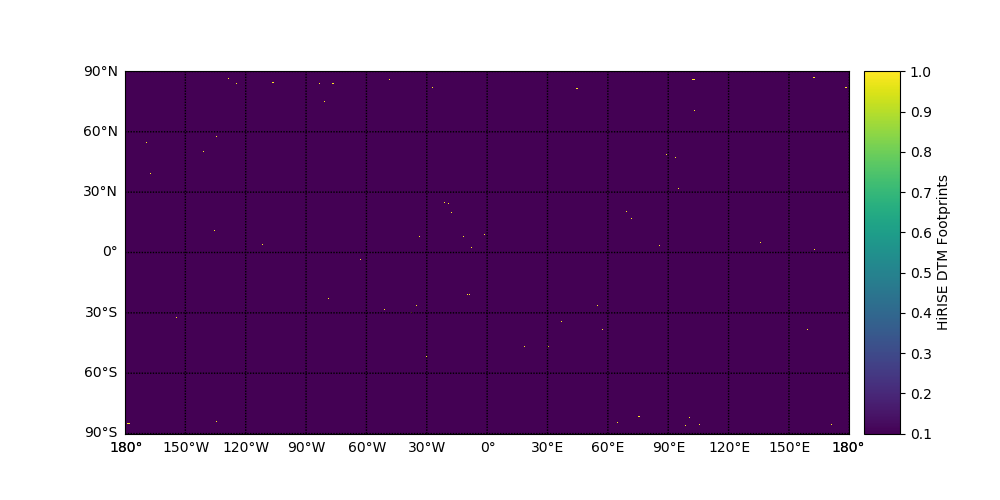

In [30]:
figure1 = plt.figure(figsize = (10, 5))
subfigure1 = figure1.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, raster_rasterization_array, 'HiRISE DTM Footprints')
# add_vector_to_map(subfigure1, basemap1, shapefile_hirise_dtm_footprints, 'ProductId', random_colors = True, alpha = 0.25)
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

And export the map to a .tif file.

In [31]:
data_name = 'MRO_HiRISE_DTM'

file_path = base_folder + output_folder + data_name + '_Rasterized_Footprints.tif'
raster_traverse = create_raster_from_array(raster_rasterization_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path,
                                           options = ['COMPRESS=DEFLATE', 'PREDICTOR=3', 'TILED=YES'])
raster_traverse = None

In [32]:
shapefile_hirise_dtm_footprints.Destroy()
raster_rasterization = None
raster_rasterization_array = None

**HRSC**

http://ode.rsl.wustl.edu/mars/coverage/ODE_Mars_shapefile.html

HRSC DTMRDR Coverage Files  
Resolution: 25 - 200 m/px

Import and rasterize the shapefile.

In [33]:
shapefile_hrsc_footprints = open_shapefile(base_folder + 'Original_Data/MEX/HRSC/mars_mex_hrsc_dtmrdr_c0a/mars_mex_hrsc_dtmrdr_c0a.shp')

print_shapefile_field_names(shapefile_hrsc_footprints)

 _______________________________________________________________________________
/ Shapefile field names:
| 
| CenterLat | CenterLon | MaxLat | MinLat | EastLon | WestLon | EmAngle | InAngle | PhAngle | SolLong | NPoleState | SPoleState | Target | ProductId | DatasetId | InstHostId | InstId | UTCstart | UTCend | PDSVolId | ProdType | CreateDate | ShpSource | ExtURL | Ext2URL | Ext3URL | ProdURL | FilesURL | LabelURL | PILOTURL | ODEId | SubSiteTag 
\_______________________________________________________________________________


In [34]:
projection = shapefile_hrsc_footprints.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Float64

raster_rasterization = rasterize_shapefile(shapefile_hrsc_footprints, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection,
                                           fill_value = 1,
                                           background_value = 0.1)
raster_rasterization_array = get_raster_array(raster_rasterization)

<IPython.core.display.Javascript object>


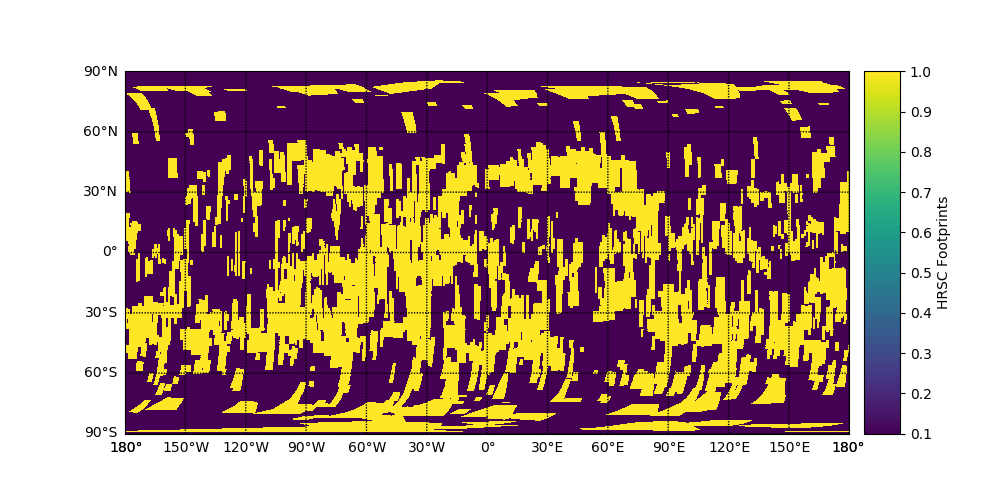

In [35]:
figure1 = plt.figure(figsize = (10, 5))
subfigure1 = figure1.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, raster_rasterization_array, 'HRSC Footprints')
# add_vector_to_map(subfigure1, basemap1, shapefile_hrsc_footprints, 'ProductId', random_colors = True, alpha = 0.25)
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

Export the map to a .tif file.

In [36]:
data_name = 'MEX_HRSC'

file_path = base_folder + output_folder + data_name + '_Rasterized_Footprints.tif'
raster_traverse = create_raster_from_array(raster_rasterization_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path,
                                           options = ['COMPRESS=DEFLATE', 'PREDICTOR=3', 'TILED=YES'])
raster_traverse = None

In [37]:
shapefile_hrsc_footprints.Destroy()
raster_rasterization = None
raster_rasterization_array = None

### Visible images

**HiRISE**

http://ode.rsl.wustl.edu/mars/coverage/ODE_Mars_shapefile.html

File MRO HiRISE RDRV11 Coverage Files  
Resolution: 0.25 - 0.5 m/px

Import and rasterize the shapefile.

In [38]:
shapefile_hirise_footprints = open_shapefile(base_folder + 'Original_Data/MRO/HiRISE/mars_mro_hirise_rdrv11_c0a/mars_mro_hirise_rdrv11_c0a.shp')
shapefile_hirise_footprints_part2 = open_shapefile(base_folder + 'Original_Data/MRO/HiRISE/mars_mro_hirise_rdr_c0a/mars_mro_hirise_rdr_c0a.shp')

print_shapefile_field_names(shapefile_hirise_footprints)
print_shapefile_field_names(shapefile_hirise_footprints_part2)

 _______________________________________________________________________________
/ Shapefile field names:
| 
| CenterLat | CenterLon | MaxLat | MinLat | EastLon | WestLon | EmAngle | InAngle | PhAngle | SolLong | NPoleState | SPoleState | Target | ProductId | DatasetId | InstHostId | InstId | UTCstart | UTCend | PDSVolId | ProdType | CreateDate | ShpSource | ExtURL | Ext2URL | Ext3URL | ProdURL | FilesURL | LabelURL | PILOTURL | ODEId | SubSiteTag 
\_______________________________________________________________________________
 _______________________________________________________________________________
/ Shapefile field names:
| 
| CenterLat | CenterLon | MaxLat | MinLat | EastLon | WestLon | EmAngle | InAngle | PhAngle | SolLong | NPoleState | SPoleState | Target | ProductId | DatasetId | InstHostId | InstId | UTCstart | UTCend | PDSVolId | ProdType | CreateDate | ShpSource | ExtURL | Ext2URL | Ext3URL | ProdURL | FilesURL | LabelURL | PILOTURL | ODEId | SubSiteTag 
\____________

In [39]:
hirise_projection = shapefile_hirise_footprints.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Float64

raster_rasterization = rasterize_shapefile(shapefile_hirise_footprints, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection,
                                           fill_value = 1,
                                           background_value = 0.1)
raster_rasterization_array = get_raster_array(raster_rasterization)

raster_rasterization_part2 = rasterize_shapefile(shapefile_hirise_footprints_part2, 
                                                 None,
                                                 data_type,
                                                 master_width, 
                                                 master_height,                    
                                                 master_geotransform, 
                                                 projection,
                                                 fill_value = 1,
                                                 background_value = 0.1)
raster_rasterization_part2_array = get_raster_array(raster_rasterization_part2)

raster_rasterization_array[raster_rasterization_part2_array == 1] = 1

<IPython.core.display.Javascript object>


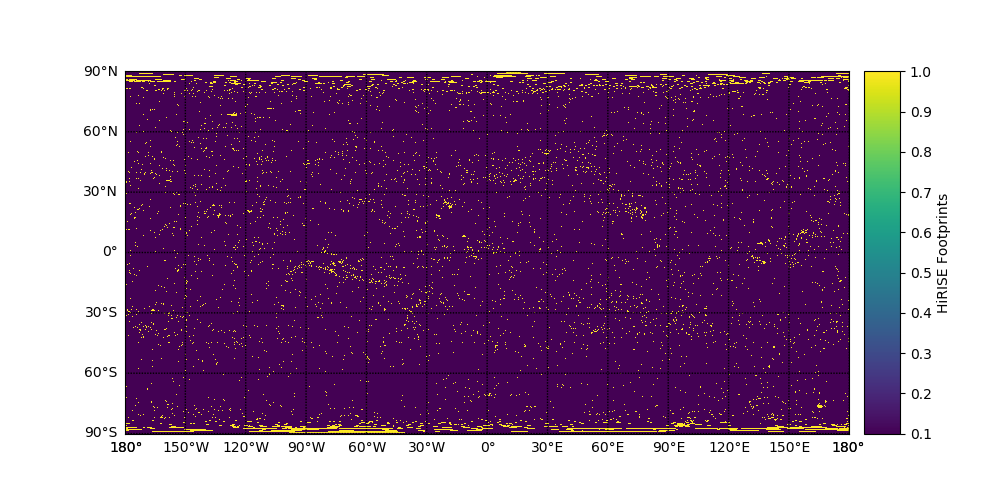

In [40]:
figure1 = plt.figure(figsize = (10, 5))
subfigure1 = figure1.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, raster_rasterization_array, 'HiRISE Footprints')
# add_vector_to_map(subfigure1, basemap1, shapefile_hirise_footprints, 'ProductId', random_colors = True, alpha = 0.25)
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

Export the map to a .tif file.

In [41]:
data_name = 'MRO_HiRISE'

file_path = base_folder + output_folder + data_name + '_Rasterized_Footprints.tif'
raster_traverse = create_raster_from_array(raster_rasterization_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path,
                                           options = ['COMPRESS=DEFLATE', 'PREDICTOR=3', 'TILED=YES'])
raster_traverse = None

In [42]:
shapefile_hirise_footprints.Destroy()
shapefile_hirise_footprints_part2.Destroy()
raster_rasterization = None
raster_rasterization_array = None
raster_rasterization_part2 = None
raster_rasterization_part2_array = None

### Infrared images

**CRISM**

http://ode.rsl.wustl.edu/mars/coverage/ODE_Mars_shapefile.html

MRO CRISM TRDR/DDR FRT/HRL/HRS/FRS/ATO/ATU Coverage Files  
Resolution: 18 - 36 m/px

Import and rasterize the shapefile.

In [43]:
shapefile_crism_footprints = open_shapefile(base_folder + 'Original_Data/MRO/CRISM/mars_mro_crism_trdrddrfrt_c0a/mars_mro_crism_trdrddrfrt_c0a.shp')
shapefile_crism_footprints_part2 = open_shapefile(base_folder + 'Original_Data/MRO/CRISM/mars_mro_crism_trdrddrfrt_c0a/mars_mro_crism_trdrddrfrt_c0a_part2.shp')

print_shapefile_field_names(shapefile_crism_footprints)
print_shapefile_field_names(shapefile_crism_footprints_part2)

 _______________________________________________________________________________
/ Shapefile field names:
| 
| CenterLat | CenterLon | MaxLat | MinLat | EastLon | WestLon | EmAngle | InAngle | PhAngle | SolLong | NPoleState | SPoleState | Target | ProductId | DatasetId | InstHostId | InstId | UTCstart | UTCend | PDSVolId | ProdType | CreateDate | ShpSource | ExtURL | Ext2URL | Ext3URL | ProdURL | FilesURL | LabelURL | PILOTURL | ODEId | SubSiteTag 
\_______________________________________________________________________________
 _______________________________________________________________________________
/ Shapefile field names:
| 
| CenterLat | CenterLon | MaxLat | MinLat | EastLon | WestLon | EmAngle | InAngle | PhAngle | SolLong | NPoleState | SPoleState | Target | ProductId | DatasetId | InstHostId | InstId | UTCstart | UTCend | PDSVolId | ProdType | CreateDate | ShpSource | ExtURL | Ext2URL | Ext3URL | ProdURL | FilesURL | LabelURL | PILOTURL | ODEId | SubSiteTag 
\____________

In [44]:
projection = shapefile_crism_footprints.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Float64

raster_rasterization = rasterize_shapefile(shapefile_crism_footprints, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection,
                                           fill_value = 1,
                                           background_value = 0.1)
raster_rasterization_array = get_raster_array(raster_rasterization)

raster_rasterization_part2 = rasterize_shapefile(shapefile_crism_footprints_part2, 
                                                 None,
                                                 data_type,
                                                 master_width, 
                                                 master_height,                    
                                                 master_geotransform, 
                                                 projection,
                                                 fill_value = 1,
                                                 background_value = 0.1)
raster_rasterization_part2_array = get_raster_array(raster_rasterization_part2)

raster_rasterization_array[raster_rasterization_part2_array == 1] = 1

<IPython.core.display.Javascript object>


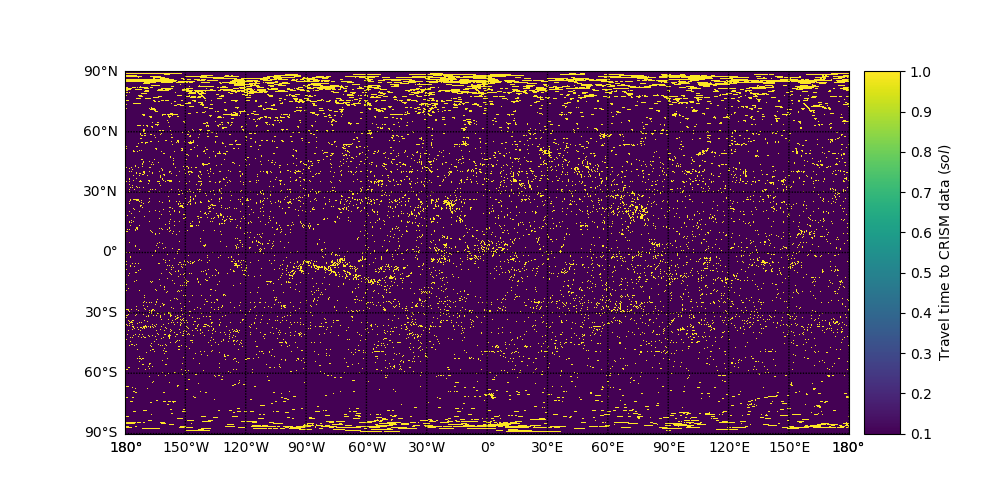

In [45]:
figure1 = plt.figure(figsize = (10, 5))
subfigure1 = figure1.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, raster_rasterization_array, 'Travel time to CRISM data ($sol$)')
# add_vector_to_map(subfigure1, basemap1, shapefile_crism_footprints, 'ProductId', random_colors = True, alpha = 0.25)
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

Export the map to a .tif file.

In [46]:
data_name = 'MRO_CRISM'

file_path = base_folder + output_folder + data_name + '_Rasterized_Footprints.tif'
raster_traverse = create_raster_from_array(raster_rasterization_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path,
                                           options = ['COMPRESS=DEFLATE', 'PREDICTOR=3', 'TILED=YES'])
raster_traverse = None

In [47]:
shapefile_crism_footprints.Destroy()
shapefile_crism_footprints_part2.Destroy()
raster_rasterization = None
raster_rasterization_array = None
raster_rasterization_part2 = None
raster_rasterization_part2_array = None

## Traversability for NASA's Mars 2020 rover

To study the rover mobility, we need a map of the rover speed depending on the terrain. Here we use the slope and the thermophysical units to characterize the Martian terrains and assign them a speed. Other data such as the rock abundance would add more value to that classification, but the resolution of most global data of Mars is currently too low.

**Relationship between the thermophysical surface units and the terrain characteristics**

<p>[Mellon et al., 2000, Putzig et al., 2005; Putzig, 2006 and Jones et al., 2014]</p>
<dl>
  <dt>Class A</dt>
  <dd>Low thermal inertia and high albedo &rarr; surfaces dominated by unconsolidated fines</dd>
  <dd>Grainsize &lt; 40 &micro;m</dd>
  <dd>Bright unconsolidated fines</dd>
  <dd>Thick covering of dust and bright unconsolidated fines, some exposures of darker fine sand</dd>
  <dd>Generally Grainsize &lt; 100 &micro;m</dd>
  <dt>Class B</dt>
  <dd>High thermal inertia and low albedo &rarr; surfaces composed of coarser-grained sediments, rocks, bedrock exposures, and some duricrust</dd>
  <dd>Sand, rocks, and bedrock; some duricrust</dd>
  <dd>Fine-coarse sand, some duricrust, and low dust coverage</dd>
  <dd>Generally 60 &micro;m &lt; Grainsize &lt; 3 mm</dd>
  <dt>Class C</dt>
  <dd>High thermal inertia and intermediate albedo &rarr; surfaces dominated by duricrust with some rocks and/or bedrock exposures</dd>
  <dd>Duricrust; some sand, rocks and bedrock</dd>
  <dd>Mixture of bright dust and fine sand, with a small fraction of coarse sand and duricrust</dd>
  <dd>Predominately Grainsize &lt; 1 mm</dd>
</dl>
<dl>
  <dt>Class D</dt>
  <dd>Low thermal inertia and low-to-intermediate albedo</dd>
  <dd>Low density mantle or dark dust?</dd>
  <dd>Fine sand with some dust covering. Similar to class 6 but with a lower subpixel coverage of bright fines</dd>
  <dd>Grainsize &lt; 100 &micro;m</dd>
  <dt>Class E</dt>
  <dd>Very low albedo</dd>
  <dd>As B, but little or no fines</dd>
  <dd>Dark fines, with some coarse sand and duricrust; very little dust</dd>
  <dd>Grainsize &lt; 3 mm</dd>
  <dt>Class F</dt>
  <dd>Very high thermal inertia</dd>
  <dd>Rocks, bedrock, duricrust, and polar ice</dd>
  <dd>Dominated by pebbles, boulders, ice-cemented soil, and exposed ice. Some duricrust and sand. Dust coverage varies</dd>
  <dd>100 &micro;m &lt; Grainsize</dd>
  <dt>Class G</dt>
  <dd>Very high albedo</dd>
  <dd>As A, thermally thin at higher inertia</dd>
  <dd>Bright dust covering fines, duricrust, and ice-cemented soil. Some exposed ice but with a substantial fine component</dd>
</dl>

**Mars Science Laboratory driving modes (similar to those of the Mars 2020 rover)**

<p>[Golombek et al., 2012] </p>

<p>Four drive modes: </p>

<dl>
  <dt>Blind</dt>
  <dd>114 m.h<sup>-1</sup></dd>
  <dd>No obstacles, low-slope terrain</dd>
  <dd>Slope &lt; 10 &deg; and no rocks, scarps or eolian bedforms</dd>
  <dt>AutoNav</dt>
  <dd>45 m.h<sup>-1</sup></dd>
  <dd>Obstacles, rugged terrain, scarps</dd>
  <dd>Rocks, scarps or eolian bedforms</dd>
  <dt>Visodom</dt>
  <dd>29 m.h<sup>-1</sup></dd>
  <dd>High-slope terrain, cohesionless terrain</dd>
  <dd>Slope &ge; 10 &deg;</dt>
  <dt>AutoNav + Visodom</dt>
  <dd>20 m.h<sup>-1</sup></dd>
  <dd>Rugged, sloped terrain</dd>
  <dd>Slope &ge; 10 &deg; and rocks, scarps or eolian bedforms</dd>
</dl>

<p>With an other mode in the path selection process: </p>

<dl>
  <dt>Unknown</dt>
  <dd>&lt; 20 m.h<sup>-1</sup></dd>
  <dd>Area without data</dd>
  <dd>Lower speed to minimize their selection</dd>
</dl>

<p>"Areas that exceeded 30 &deg; are considered too steep to drive up. Areas with slopes less than 15 &deg; are considered traversable and areas with slopes in between can be driven up if the surface is outcrop [and not some poorly consolidated sediments]. The rover is stable on slopes of up to 45 &deg;, so this is the limit assumed if the rover were to land on top of a steep sided mesa and had to drive off of it to escape."</p>

<p>1 Sol = 24 h 39 min 35.244 s = 24.65979 h</p>

We first import the slope and the thermophysical units.

In [48]:
raster_slope = open_raster(base_folder + output_folder + 'MGS_MOLA_Slope_1km.tif')
print_raster_info(raster_slope)
raster_slope_array = get_raster_array(raster_slope)

raster_thermophy = open_raster(base_folder + output_folder + 'MGS_TES_Thermophysical_Surface_Units.tif')
print_raster_info(raster_thermophy)
raster_thermophy_array = get_raster_array(raster_thermophy)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )
Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin 

Then, we can classify the terrains depending on those two features, and assign them a speed value based on the rover's driving modes. 

In [49]:
rover_speed_array = np.full((master_height, master_width), np.nan)

unknown_indices = np.where(((np.isnan(raster_slope_array)) |
                            (raster_slope_array < 30)) &
                           (np.isnan(raster_thermophy_array)))
rover_speed_array[unknown_indices] = 10*24.65979

nogo_indices = np.where((raster_slope_array >= 30) | 
                        ((raster_slope_array >= 15) &
                         (raster_thermophy_array == 3)) | 
                        ((raster_thermophy_array == 1) | 
                         (raster_thermophy_array == 4) | 
                         (raster_thermophy_array == 7)))
rover_speed_array[nogo_indices] = 0

autonav_indices = np.where((raster_slope_array < 10) &
                           ((raster_thermophy_array == 2) | 
                            (raster_thermophy_array == 3) | 
                            (raster_thermophy_array == 5) | 
                            (raster_thermophy_array == 6)))
rover_speed_array[autonav_indices] = 45*24.65979

visodom_indices = np.where((raster_slope_array >= 10) &
                           (raster_slope_array < 30) &
                           ((raster_thermophy_array == 2) | 
                            (raster_thermophy_array == 5) | 
                            (raster_thermophy_array == 6)))
rover_speed_array[visodom_indices] = 29*24.65979

autonavvisodom_indices = np.where((raster_slope_array >= 10) &
                                  (raster_slope_array < 15) &
                                  (raster_thermophy_array == 3))
rover_speed_array[autonavvisodom_indices] = 20*24.65979

<IPython.core.display.Javascript object>


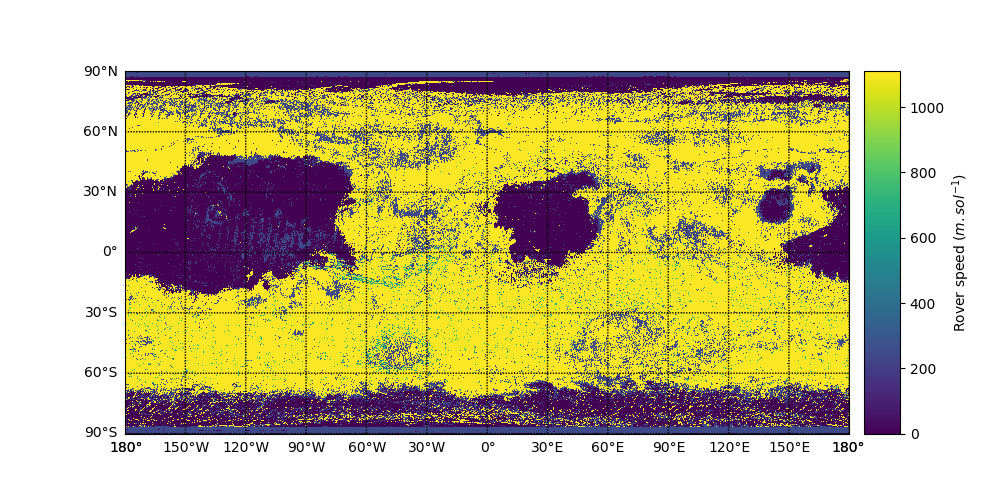

In [50]:
figure1 = plt.figure(figsize = (10, 5))
subfigure1 = figure1.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, rover_speed_array, 'Rover speed ($m.sol^{-1}$)')
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

Export the map to a .tif file.

In [51]:
raster_rover_speed = create_raster_from_array(rover_speed_array,           
                                              master_geotransform, 
                                              master_projection,
                                              file_type = 'GTiff',
                                              file_path = base_folder + output_folder + 'Interpreted_Data_Rover_Speed.tif',
                                              options = ['COMPRESS=DEFLATE', 'PREDICTOR=3', 'TILED=YES'])
raster_rover_speed = None

In [52]:
raster_thermophy = None
raster_thermophy_array = None
raster_slope = None
raster_slope_array = None
raster_rover_speed_array = None

## Traversability for future rovers

The following maps will be used to analyze the exploration potential when the rovers' capabilities improve. It implies that some of the next notebooks need to be run several times to account for the different speed maps.

### Rovers with increasing speed

First, we change the maximum speed of the rover.

In [71]:
rover_type = 'Automated'
# rover_type = 'Remotely-controlled'
# rover_type = 'Human-driven'

rover_speed_array = np.full((master_height, master_width), np.nan)

full_speed = 0
speed_affix = '_NoSpeed'
# E.g., Curiosity
if rover_type == 'Automated':
    full_speed = 100
    speed_affix = '_Speed100'
# E.g., Lunokhod 2
elif rover_type == 'Remotely-controlled':
    full_speed = 1000
    speed_affix = '_Speed1000'
# E.g., Lunar Roving Vehicle
elif rover_type == 'Human-driven':
    full_speed = 10000
    speed_affix = '_Speed10000'

We import the slope and the thermophysical units if not already done.

In [72]:
raster_slope = open_raster(base_folder + output_folder + 'MGS_MOLA_Slope_1km.tif')
print_raster_info(raster_slope)
raster_slope_array = get_raster_array(raster_slope)

raster_thermophy = open_raster(base_folder + output_folder + 'MGS_TES_Thermophysical_Surface_Units.tif')
print_raster_info(raster_thermophy)
raster_thermophy_array = get_raster_array(raster_thermophy)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )
Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin 

And we classify the terrains depending on their thermophysical unit and the slope, and assign them a speed value based on the rover's type. 

In [73]:
rover_speed_array = np.full((master_height, master_width), np.nan)

unknown_indices = np.where(((np.isnan(raster_slope_array)) |
                            (raster_slope_array < 30)) &
                           (np.isnan(raster_thermophy_array)))
rover_speed_array[unknown_indices] = (full_speed/10.)*24.65979

nogo_indices = np.where((raster_slope_array >= 30) | 
                        ((raster_slope_array >= 15) &
                         (raster_thermophy_array == 3)) | 
                        ((raster_thermophy_array == 1) | 
                         (raster_thermophy_array == 4) | 
                         (raster_thermophy_array == 7)))
rover_speed_array[nogo_indices] = 0

autonav_indices = np.where((raster_slope_array < 10) &
                           ((raster_thermophy_array == 2) | 
                            (raster_thermophy_array == 3) | 
                            (raster_thermophy_array == 5) | 
                            (raster_thermophy_array == 6)))
rover_speed_array[autonav_indices] = full_speed*24.65979

visodom_indices = np.where((raster_slope_array >= 10) &
                           (raster_slope_array < 30) &
                           ((raster_thermophy_array == 2) | 
                            (raster_thermophy_array == 5) | 
                            (raster_thermophy_array == 6)))
rover_speed_array[visodom_indices] = (full_speed/2.)*24.65979

autonavvisodom_indices = np.where((raster_slope_array >= 10) &
                                  (raster_slope_array < 15) &
                                  (raster_thermophy_array == 3))
rover_speed_array[autonavvisodom_indices] = (full_speed/3.)*24.65979

<IPython.core.display.Javascript object>


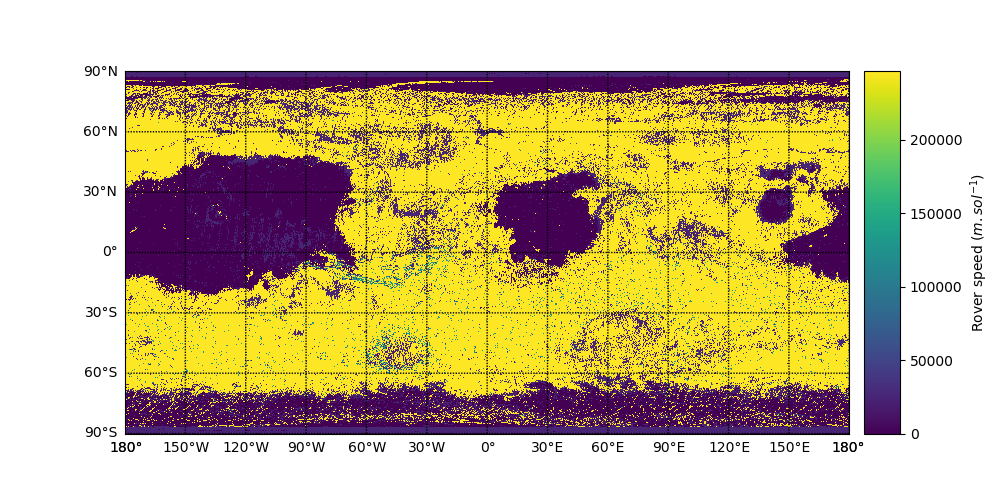

In [74]:
figure1 = plt.figure(figsize = (10, 5))
subfigure1 = figure1.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, rover_speed_array, 'Rover speed ($m.sol^{-1}$)')
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

Export the map to a .tif file.

In [75]:
raster_rover_speed = create_raster_from_array(rover_speed_array,           
                                              master_geotransform, 
                                              master_projection,
                                              file_type = 'GTiff',
                                              file_path = base_folder + output_folder + 'Interpreted_Data_Rover_Speed' + speed_affix + '.tif',
                                              options = ['COMPRESS=DEFLATE', 'PREDICTOR=3', 'TILED=YES'])
raster_rover_speed = None

In [76]:
raster_thermophy = None
raster_thermophy_array = None
raster_slope = None
raster_slope_array = None
raster_rover_speed_array = None

### Rover able to traverse dusty areas

Second, we allow the rover to drive on dusty areas.

In [59]:
speed_affix = '_DustTraversable'

Again, import the slope and the thermophysical units if not already done.

In [60]:
raster_slope = open_raster(base_folder + output_folder + 'MGS_MOLA_Slope_1km.tif')
print_raster_info(raster_slope)
raster_slope_array = get_raster_array(raster_slope)

raster_thermophy = open_raster(base_folder + output_folder + 'MGS_TES_Thermophysical_Surface_Units.tif')
print_raster_info(raster_thermophy)
raster_thermophy_array = get_raster_array(raster_thermophy)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )
Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin 

And we classify the terrains depending on their thermophysical unit and the slope, and assign them a speed value based on Curiosity's driving modes, except that the dusty areas are traversable at a normal speed. 

In [61]:
rover_speed_array = np.full((master_height, master_width), np.nan)

unknown_indices = np.where(np.isnan(raster_slope_array))
rover_speed_array[unknown_indices] = 10*24.65979

nogo_indices = np.where((raster_slope_array >= 30))
rover_speed_array[nogo_indices] = 0

autonav_indices = np.where((raster_slope_array < 10))
rover_speed_array[autonav_indices] = 45*24.65979

visodom_indices = np.where((raster_slope_array >= 10) &
                           (raster_slope_array < 30))
rover_speed_array[visodom_indices] = 29*24.65979

<IPython.core.display.Javascript object>


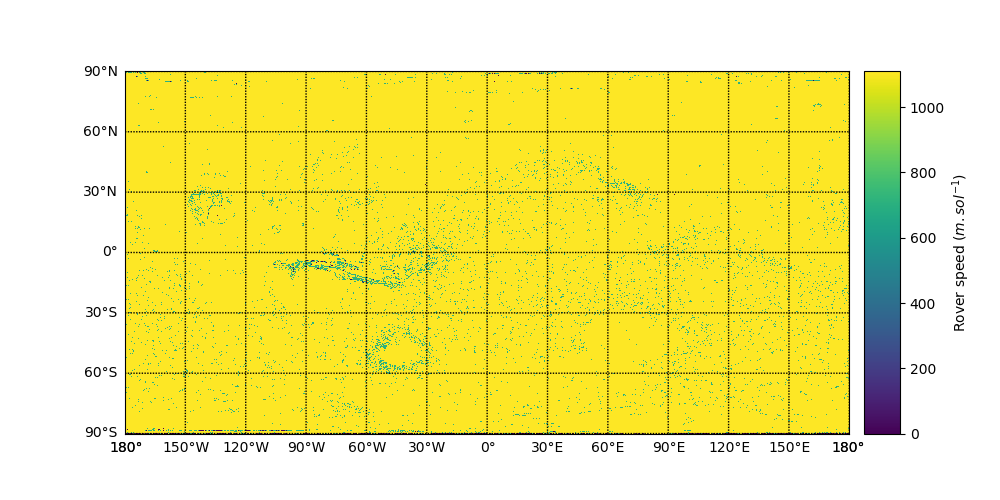

In [62]:
figure1 = plt.figure(figsize = (10, 5))
subfigure1 = figure1.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, rover_speed_array, 'Rover speed ($m.sol^{-1}$)')
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

Export the map to a .tif file.

In [63]:
raster_rover_speed = create_raster_from_array(rover_speed_array,           
                                              master_geotransform, 
                                              master_projection,
                                              file_type = 'GTiff',
                                              file_path = base_folder + output_folder + 'Interpreted_Data_Rover_Speed' + speed_affix + '.tif',
                                              options = ['COMPRESS=DEFLATE', 'PREDICTOR=3', 'TILED=YES'])
raster_rover_speed = None

In [64]:
raster_thermophy = None
raster_thermophy_array = None
raster_slope = None
raster_slope_array = None
raster_rover_speed_array = None